# Deep Learning aplicado à análise de imagens de mamografia
### Base de dados: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629 

In [1]:
from itertools import product #

#system related
import time #
from pathlib import Path 
import warnings #

#data manipulation / preparation
import numpy as np
import pandas as pd
import json

#image manipulation
import pydicom as dicom
from skimage import draw, transform
from skimage.transform import resize
from skimage.color import gray2rgb

#model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LeakyReLU, Conv2D, Activation, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout,InputLayer, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import SGD, Adam

#metrics
from sklearn import metrics

#plotting
import matplotlib.pylab as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
from matplotlib import gridspec #
%matplotlib inline

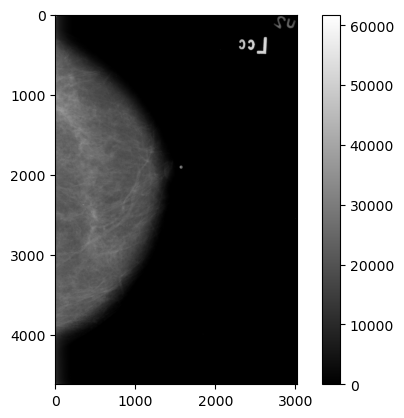

In [2]:
#Abrindo uma imagem dicom a partir de um caminho específico
image_path = r'C:\Users\dsrre\Documents\TCC MBA\4.10 Reconhecimento de imagem\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-2017-DDSM-NA-96009\1.000000-full mammogram images-63992\1-1.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap="gray")
plt.colorbar()

In [3]:
#Carregando conjunto de treino para calc
calc_train_df = pd.read_csv("calc_case_description_train_set.csv")

#Carregando conjunto de test para calc
calc_test_df = pd.read_csv("calc_case_description_test_set.csv")

#Carregando conjunto de treino para mass
mass_train_df = pd.read_csv("mass_case_description_train_set.csv")

#Carregando conjunto de teste para mass
mass_test_df = pd.read_csv("mass_case_description_test_set.csv")

In [4]:
calc_train_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [5]:
#Removendo linhas contendo elementos nulos
calc_te = calc_test_df.dropna()

calc_tr = calc_train_df.dropna()

mass_te = mass_test_df.dropna()

mass_tr = mass_train_df.dropna()

In [6]:
#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
calc_tr = calc_tr[calc_tr.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
calc_te = calc_te[calc_te.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
mass_tr = mass_tr[mass_tr.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
mass_te = mass_te[mass_te.pathology != 'BENIGN_WITHOUT_CALLBACK']

In [7]:
#0 = ausência de câncer; 1 = presença de câncer
calc_tr['pathology'] = calc_tr['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
calc_te['pathology'] = calc_te['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
mass_tr['pathology'] = mass_tr['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
mass_te['pathology'] = mass_te['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])

In [8]:
''' Unindo 4 dataframes em um só em etapas sucessivas pois não é possível unir mais de 2 simultaneamente.
    Esse procedimento é para possibilitar a criação de uma lista posteriormente, facilitando a futura
    criação de um dicionário contendo ids e paths. '''
mam = pd.merge(calc_te, calc_tr, how = 'outer')
mamm = pd.merge(mam, mass_te, how = 'outer')
mammography = pd.merge(mamm, mass_tr, how = 'outer')
mammography.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,breast_density,mass shape,mass margins
0,P_00038,2.0,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,0,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,NaN,NaN,NaN
1,P_00038,2.0,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,0,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,NaN,NaN,NaN
2,P_00100,4.0,RIGHT,CC,1,calcification,PLEOMORPHIC,CLUSTERED,4,0,4,Calc-Test_P_00100_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00100_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00100_RIGHT_CC_1/1.3.6.1.4.1.9590....,NaN,NaN,NaN
3,P_00100,4.0,RIGHT,MLO,1,calcification,PLEOMORPHIC,CLUSTERED,4,0,4,Calc-Test_P_00100_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00100_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00100_RIGHT_MLO_1/1.3.6.1.4.1.9590...,NaN,NaN,NaN
4,P_00127,2.0,RIGHT,CC,1,calcification,PLEOMORPHIC,CLUSTERED,4,1,3,Calc-Test_P_00127_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590....,NaN,NaN,NaN


In [9]:
print(len(mammography))

2856


In [10]:
mammography.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path', 'breast_density',
       'mass shape', 'mass margins'],
      dtype='object')

In [11]:
path_list = mammography['ROI mask file path'].tolist()

In [12]:
subs = []
for path in path_list:
    subs.append(path.split("/"))  

In [13]:
paths = []
for elem in subs:
    paths.append(elem[0])

In [14]:
dir_origin = Path(r'C:\Users\dsrre\Documents\TCC MBA\4.10 Reconhecimento de imagem\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM')

all_images = []
def scan_folder(parent):
    ''' Esta função percorre subpastas presentes em um diretório em busca de arquivos com extensão .dcm.
        Parâmetro: diretório pai.
    '''
    for file_path in parent.iterdir():  # Objetos pathlib.Path tem o método "iterdir"
        if file_path.suffix == ".dcm":  # e tem o atributo ".suffix" que é a extensão do arquivo, incluindo o "."
#            print(file_path)    
            all_images.append(file_path)
        elif file_path.is_dir():  # e tem o método "is_dir" pra saber se o objeto é um diretório
            # current_path = "".join((parent, "/", file_name))  # < não precisa deesse passo, já estamos "vendo" o caminho completo para o novo diretório
            scan_folder(file_path)        
    return

scan_folder(dir_origin)
#print(all_images)

In [15]:
image_list = []
for _ in all_images:
    image_list.append(r'{}'.format(str(_)))

In [16]:
''' Criando dicionário onde as ids são as chaves e os paths os valores. Isso é feito para filtrar as imagens a serem
    treinadas na rede. '''
dict_images = {id: list(elem for elem in image_list if id in elem) for id in paths}
#print(json.dumps(dict_images, indent=4))  

In [17]:
resultlist = list(dict_images.values())
#print(resultlist)

In [18]:
img_dcm = []
for elem in resultlist:
    img_dcm.append(elem[0])

In [19]:
path_calc_test = img_dcm[0:257]
path_calc_train = img_dcm[257:1322]
path_mass_test = img_dcm[1322:1660]
path_mass_train = img_dcm[1660:2856]

In [20]:
print(len(path_calc_test), len(path_calc_train), len(path_mass_test), len(path_mass_train))

257 1065 338 1196


In [21]:
calc_tr['paths'] = path_calc_train
calc_te['paths'] = path_calc_test
mass_tr['paths'] = path_mass_train
mass_te['paths'] = path_mass_test

patho_calc_train = calc_tr['pathology'].tolist()
patho_calc_test = calc_te['pathology'].tolist()
patho_mass_train = mass_tr['pathology'].tolist()
patho_mass_test = mass_te['pathology'].tolist()

In [22]:
#Reduzindo os conjuntos de treino e teste 75% e 25% 
calc_train = calc_tr.iloc[0:600]
calc_test = calc_te.iloc[0:200]
mass_train = mass_tr.iloc[0:600]
mass_test = mass_te.iloc[0:200]

pathology_calc_train = patho_calc_train[0:600]
pathology_calc_test = patho_calc_test[0:200]
pathology_mass_train = patho_mass_train[0:600]
pathology_mass_test = patho_mass_test[0:200]

calc_train_list = calc_train['paths'].tolist()
calc_test_list = calc_test['paths'].tolist()
mass_train_list = mass_train['paths'].tolist()
mass_test_list = mass_test['paths'].tolist()

# Pré processamento das imagens

In [23]:
X_calc_train, y_calc_train, X_mass_train, y_mass_train = [], [], [], []
X_calc_test, y_calc_test, X_mass_test, y_mass_test = [], [], [], []

In [24]:
def resize_img(pixels): 
    return resize(pixels, (256, 256), anti_aliasing = True).astype(float)

In [25]:
for elem in calc_test_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_calc_test.append(pixels)
    
for elem in calc_train_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_calc_train.append(pixels)
    
for elem in mass_test_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_mass_test.append(pixels)
    
for elem in mass_train_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_mass_train.append(pixels)

In [26]:
for elem in pathology_calc_test:
    y_calc_test.append(elem)
    
for elem in pathology_calc_train:
    y_calc_train.append(elem)
    
for elem in pathology_mass_test:
    y_mass_test.append(elem)
    
for elem in pathology_mass_train:
    y_mass_train.append(elem)

In [27]:
X_calc_train = np.asarray(X_calc_train)
X_calc_test = np.asarray(X_calc_test)
X_mass_train = np.asarray(X_mass_train)
X_mass_test = np.asarray(X_mass_test)

y_calc_train = np.asarray(y_calc_train)
y_calc_test = np.asarray(y_calc_test)
y_mass_train = np.asarray(y_mass_train)
y_mass_test = np.asarray(y_mass_test)

X_calc_train = gray2rgb(X_calc_train)
X_calc_test = gray2rgb(X_calc_test)
X_mass_train = gray2rgb(X_mass_train)
X_mass_test = gray2rgb(X_mass_test)

# Modelo

In [28]:
def Build_CNN_Model(X_train):
    model = Sequential()

    model.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = "relu", input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size = 3, padding = 'same',  activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))
    
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = "sigmoid"))
    
    model.summary()
    
    opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [29]:
def Train_CNN_Model(model, X_train, y_train, X_test, y_test):

    #Dividindo em treino e validação
    #X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size = 0.25, random_state = 42)
    
    mean, std = X_train.mean(), X_train.std()
    X_train, X_test = (X_train - mean)/std, (X_test - mean)/std # normalize data
    
    
    history = model.fit(X_train, y_train, batch_size = 64, epochs = 300, verbose = 1, 
                            validation_data = (X_test, y_test))
    

    plt.plot(history.history['accuracy'], color = "darkorange")
    plt.plot(history.history['val_accuracy'], color = "midnightblue")
    plt.title('Acurácia do Modelo 2')
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.show()
    

    plt.plot(history.history['loss'], color = "darkorange")
    plt.plot(history.history['val_loss'], color = "midnightblue")
    plt.title('Perda do Modelo 2')
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.show()


In [30]:
model = Build_CNN_Model(X_calc_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     2

Epoch 1/300
10/10 [==============================] - 72s 7s/step - loss: 2.6484 - accuracy: 0.5183 - val_loss: 0.6957 - val_accuracy: 0.5150
Epoch 2/300
10/10 [==============================] - 74s 7s/step - loss: 1.6429 - accuracy: 0.4933 - val_loss: 0.6970 - val_accuracy: 0.5450
Epoch 3/300
10/10 [==============================] - 59s 6s/step - loss: 1.2085 - accuracy: 0.5450 - val_loss: 0.7035 - val_accuracy: 0.4900
Epoch 4/300
10/10 [==============================] - 60s 6s/step - loss: 0.9835 - accuracy: 0.5317 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 5/300
10/10 [==============================] - 64s 6s/step - loss: 0.9455 - accuracy: 0.5450 - val_loss: 0.7010 - val_accuracy: 0.4800
Epoch 6/300
10/10 [==============================] - 64s 6s/step - loss: 0.8031 - accuracy: 0.5450 - val_loss: 0.6996 - val_accuracy: 0.4800
Epoch 7/300
10/10 [==============================] - 64s 6s/step - loss: 0.8463 - accuracy: 0.5117 - val_loss: 0.6964 - val_accuracy: 0.5050
Epoch 8/300
1

Epoch 59/300
10/10 [==============================] - 67s 7s/step - loss: 0.6478 - accuracy: 0.6200 - val_loss: 0.6996 - val_accuracy: 0.5500
Epoch 60/300
10/10 [==============================] - 62s 6s/step - loss: 0.6564 - accuracy: 0.6183 - val_loss: 0.7061 - val_accuracy: 0.5500
Epoch 61/300
10/10 [==============================] - 61s 6s/step - loss: 0.6502 - accuracy: 0.6317 - val_loss: 0.7022 - val_accuracy: 0.5450
Epoch 62/300
10/10 [==============================] - 61s 6s/step - loss: 0.6351 - accuracy: 0.6317 - val_loss: 0.7050 - val_accuracy: 0.5300
Epoch 63/300
10/10 [==============================] - 62s 6s/step - loss: 0.6532 - accuracy: 0.6250 - val_loss: 0.7011 - val_accuracy: 0.5400
Epoch 64/300
10/10 [==============================] - 64s 6s/step - loss: 0.6492 - accuracy: 0.6250 - val_loss: 0.7003 - val_accuracy: 0.5450
Epoch 65/300
10/10 [==============================] - 66s 6s/step - loss: 0.6377 - accuracy: 0.6250 - val_loss: 0.7006 - val_accuracy: 0.5500
Epoch 

10/10 [==============================] - 63s 6s/step - loss: 0.6021 - accuracy: 0.6867 - val_loss: 0.7316 - val_accuracy: 0.5600
Epoch 174/300
10/10 [==============================] - 64s 6s/step - loss: 0.6122 - accuracy: 0.6633 - val_loss: 0.7298 - val_accuracy: 0.5400
Epoch 175/300
10/10 [==============================] - 65s 7s/step - loss: 0.5914 - accuracy: 0.6750 - val_loss: 0.7258 - val_accuracy: 0.5300
Epoch 176/300
10/10 [==============================] - 67s 7s/step - loss: 0.6290 - accuracy: 0.6550 - val_loss: 0.7271 - val_accuracy: 0.5150
Epoch 177/300
10/10 [==============================] - 69s 7s/step - loss: 0.6060 - accuracy: 0.6433 - val_loss: 0.7292 - val_accuracy: 0.5450
Epoch 178/300
10/10 [==============================] - 65s 6s/step - loss: 0.6004 - accuracy: 0.6600 - val_loss: 0.7342 - val_accuracy: 0.5550
Epoch 179/300
10/10 [==============================] - 62s 6s/step - loss: 0.6111 - accuracy: 0.6633 - val_loss: 0.7291 - val_accuracy: 0.5400
Epoch 180/300

10/10 [==============================] - 66s 7s/step - loss: 0.5784 - accuracy: 0.6933 - val_loss: 0.7500 - val_accuracy: 0.5500
Epoch 288/300
10/10 [==============================] - 69s 7s/step - loss: 0.5804 - accuracy: 0.6900 - val_loss: 0.7339 - val_accuracy: 0.5400
Epoch 289/300
10/10 [==============================] - 63s 6s/step - loss: 0.5776 - accuracy: 0.6867 - val_loss: 0.7379 - val_accuracy: 0.5450
Epoch 290/300
10/10 [==============================] - 60s 6s/step - loss: 0.5701 - accuracy: 0.6783 - val_loss: 0.7533 - val_accuracy: 0.5700
Epoch 291/300
10/10 [==============================] - 62s 6s/step - loss: 0.5443 - accuracy: 0.7050 - val_loss: 0.7519 - val_accuracy: 0.5200
Epoch 292/300
10/10 [==============================] - 64s 6s/step - loss: 0.5749 - accuracy: 0.6767 - val_loss: 0.7599 - val_accuracy: 0.5250
Epoch 293/300
10/10 [==============================] - 64s 6s/step - loss: 0.5447 - accuracy: 0.6983 - val_loss: 0.8000 - val_accuracy: 0.5550
Epoch 294/300

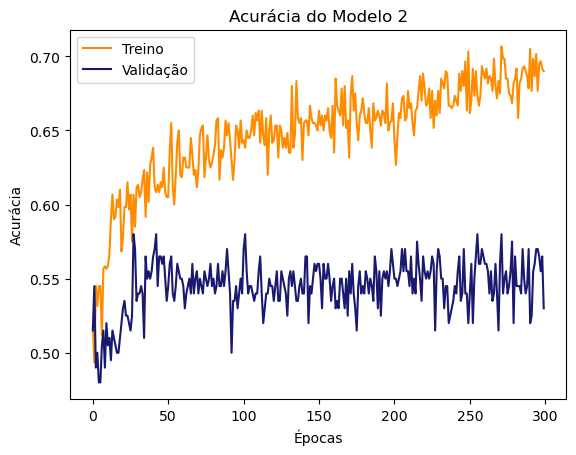

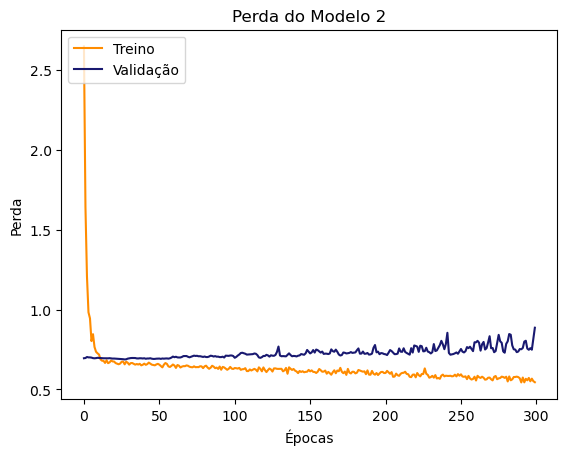

In [31]:
Train_CNN_Model(model, X_calc_train, y_calc_train, X_calc_test, y_calc_test)

In [32]:
model.save('mammography_cnn_calc.h5')

In [33]:
model2 = Build_CNN_Model(X_mass_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 64)    

Epoch 1/300
10/10 [==============================] - 71s 7s/step - loss: 3.3054 - accuracy: 0.4783 - val_loss: 0.6832 - val_accuracy: 0.5750
Epoch 2/300
10/10 [==============================] - 65s 6s/step - loss: 1.4088 - accuracy: 0.4817 - val_loss: 0.6935 - val_accuracy: 0.4500
Epoch 3/300
10/10 [==============================] - 59s 6s/step - loss: 1.0394 - accuracy: 0.4883 - val_loss: 0.6888 - val_accuracy: 0.5800
Epoch 4/300
10/10 [==============================] - 58s 6s/step - loss: 0.9365 - accuracy: 0.4967 - val_loss: 0.6896 - val_accuracy: 0.5600
Epoch 5/300
10/10 [==============================] - 58s 6s/step - loss: 0.8568 - accuracy: 0.4833 - val_loss: 0.6876 - val_accuracy: 0.5750
Epoch 6/300
10/10 [==============================] - 59s 6s/step - loss: 0.8516 - accuracy: 0.4667 - val_loss: 0.6901 - val_accuracy: 0.5700
Epoch 7/300
10/10 [==============================] - 62s 6s/step - loss: 0.7883 - accuracy: 0.4917 - val_loss: 0.6911 - val_accuracy: 0.5650
Epoch 8/300
1

Epoch 59/300
10/10 [==============================] - 67s 7s/step - loss: 0.6885 - accuracy: 0.5183 - val_loss: 0.7156 - val_accuracy: 0.4400
Epoch 60/300
10/10 [==============================] - 69s 7s/step - loss: 0.6875 - accuracy: 0.5500 - val_loss: 0.7112 - val_accuracy: 0.4550
Epoch 61/300
10/10 [==============================] - 71s 7s/step - loss: 0.6930 - accuracy: 0.5200 - val_loss: 0.7093 - val_accuracy: 0.4350
Epoch 62/300
10/10 [==============================] - 62s 6s/step - loss: 0.6867 - accuracy: 0.5367 - val_loss: 0.7107 - val_accuracy: 0.4250
Epoch 63/300
10/10 [==============================] - 66s 7s/step - loss: 0.6859 - accuracy: 0.5433 - val_loss: 0.7075 - val_accuracy: 0.4250
Epoch 64/300
10/10 [==============================] - 67s 7s/step - loss: 0.6935 - accuracy: 0.5150 - val_loss: 0.7078 - val_accuracy: 0.4300
Epoch 65/300
10/10 [==============================] - 67s 7s/step - loss: 0.6843 - accuracy: 0.5217 - val_loss: 0.7093 - val_accuracy: 0.4400
Epoch 

10/10 [==============================] - 75s 8s/step - loss: 0.6779 - accuracy: 0.5667 - val_loss: 0.7071 - val_accuracy: 0.4650
Epoch 174/300
10/10 [==============================] - 75s 8s/step - loss: 0.6838 - accuracy: 0.5417 - val_loss: 0.7053 - val_accuracy: 0.4600
Epoch 175/300
10/10 [==============================] - 68s 7s/step - loss: 0.6825 - accuracy: 0.5167 - val_loss: 0.7028 - val_accuracy: 0.4800
Epoch 176/300
10/10 [==============================] - 62s 6s/step - loss: 0.6790 - accuracy: 0.5450 - val_loss: 0.7035 - val_accuracy: 0.4700
Epoch 177/300
10/10 [==============================] - 62s 6s/step - loss: 0.6826 - accuracy: 0.5450 - val_loss: 0.6940 - val_accuracy: 0.5050
Epoch 178/300
10/10 [==============================] - 65s 7s/step - loss: 0.6746 - accuracy: 0.5650 - val_loss: 0.6917 - val_accuracy: 0.5400
Epoch 179/300
10/10 [==============================] - 65s 7s/step - loss: 0.6804 - accuracy: 0.5583 - val_loss: 0.6992 - val_accuracy: 0.4750
Epoch 180/300

10/10 [==============================] - 67s 7s/step - loss: 0.6729 - accuracy: 0.5533 - val_loss: 0.7093 - val_accuracy: 0.4850
Epoch 288/300
10/10 [==============================] - 69s 7s/step - loss: 0.6650 - accuracy: 0.5767 - val_loss: 0.7196 - val_accuracy: 0.4500
Epoch 289/300
10/10 [==============================] - 71s 7s/step - loss: 0.6844 - accuracy: 0.5383 - val_loss: 0.7171 - val_accuracy: 0.4650
Epoch 290/300
10/10 [==============================] - 63s 6s/step - loss: 0.6795 - accuracy: 0.5450 - val_loss: 0.7091 - val_accuracy: 0.4700
Epoch 291/300
10/10 [==============================] - 63s 6s/step - loss: 0.6734 - accuracy: 0.5583 - val_loss: 0.7061 - val_accuracy: 0.4750
Epoch 292/300
10/10 [==============================] - 65s 7s/step - loss: 0.6728 - accuracy: 0.5767 - val_loss: 0.7088 - val_accuracy: 0.4800
Epoch 293/300
10/10 [==============================] - 66s 7s/step - loss: 0.6750 - accuracy: 0.5667 - val_loss: 0.7146 - val_accuracy: 0.4750
Epoch 294/300

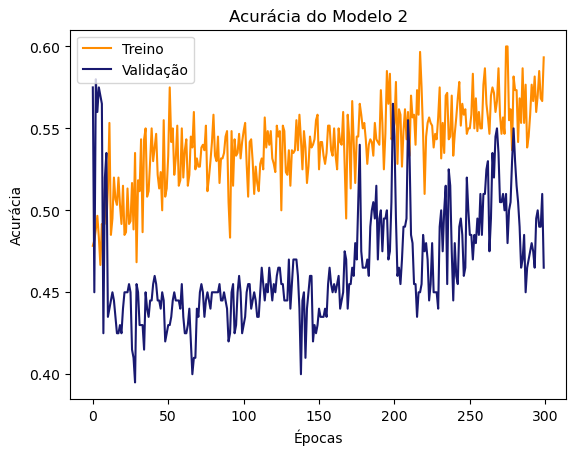

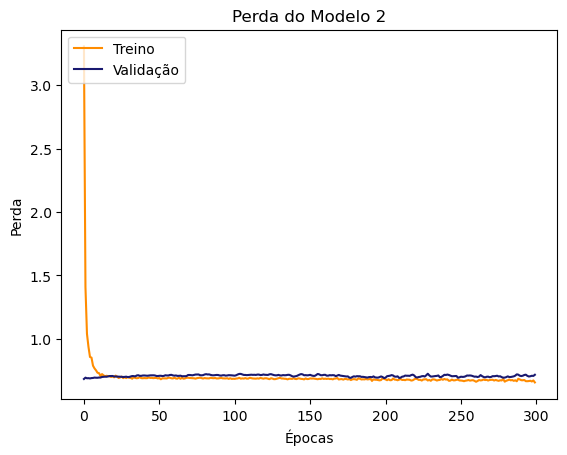

In [34]:
Train_CNN_Model(model2, X_mass_train, y_mass_train, X_mass_test, y_mass_test)

In [35]:
model2.save('mammography_cnn_mass.h5')

# Avaliação do modelo

In [36]:
y_calc = model.predict(X_calc_test)
y_mass = model2.predict(X_mass_test)

7/7 [==============================] - 4s 517ms/step


In [37]:
print(y_calc_test)

[0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1]


In [38]:
print(y_calc)

[[0.70236146]
 [0.48720542]
 [0.8436411 ]
 [0.7909411 ]
 [0.57576996]
 [0.7610571 ]
 [0.76346433]
 [0.653925  ]
 [0.32547358]
 [0.5028655 ]
 [0.70614994]
 [0.75203586]
 [0.6030771 ]
 [0.40973553]
 [0.4306383 ]
 [0.37923652]
 [0.49828443]
 [0.5693924 ]
 [0.34058502]
 [0.7263815 ]
 [0.70052   ]
 [0.74677116]
 [0.76941884]
 [0.7796721 ]
 [0.3474002 ]
 [0.3433363 ]
 [0.7343611 ]
 [0.8153034 ]
 [0.24289343]
 [0.52319306]
 [0.45719323]
 [0.3479696 ]
 [0.24304843]
 [0.44930816]
 [0.6698916 ]
 [0.6138142 ]
 [0.7004872 ]
 [0.8022029 ]
 [0.6014997 ]
 [0.3901282 ]
 [0.56590325]
 [0.42136514]
 [0.6267231 ]
 [0.83850646]
 [0.4475377 ]
 [0.49953791]
 [0.59154767]
 [0.59097415]
 [0.70332617]
 [0.6042312 ]
 [0.73681056]
 [0.37294278]
 [0.77745724]
 [0.51378244]
 [0.6575069 ]
 [0.3542227 ]
 [0.5472408 ]
 [0.43117753]
 [0.6458008 ]
 [0.18236268]
 [0.57011527]
 [0.3849097 ]
 [0.4504448 ]
 [0.44316232]
 [0.70603377]
 [0.447834  ]
 [0.38483566]
 [0.61734885]
 [0.49174833]
 [0.44047883]
 [0.5756909 ]
 [0.62

In [39]:
y_calc=[1 if x[0]>0.7 else 0 for x in y_calc]
print(y_calc)

[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]


In [40]:
print(y_mass_test)

[1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [41]:
print(y_mass)

[[0.48745704]
 [0.51157856]
 [0.36438638]
 [0.32560048]
 [0.28584272]
 [0.28961205]
 [0.22748244]
 [0.24810575]
 [0.2772908 ]
 [0.21356717]
 [0.4046546 ]
 [0.2954706 ]
 [0.4597971 ]
 [0.34112313]
 [0.45515805]
 [0.40124127]
 [0.35857087]
 [0.28707287]
 [0.2954196 ]
 [0.3734558 ]
 [0.3147127 ]
 [0.38679516]
 [0.31062394]
 [0.4678236 ]
 [0.21737766]
 [0.36281863]
 [0.34206146]
 [0.2798519 ]
 [0.31193233]
 [0.26733628]
 [0.4431581 ]
 [0.25067404]
 [0.2865223 ]
 [0.4144178 ]
 [0.40348163]
 [0.4330294 ]
 [0.34362894]
 [0.3112106 ]
 [0.4660722 ]
 [0.4990279 ]
 [0.48548153]
 [0.4461844 ]
 [0.35597968]
 [0.31468338]
 [0.33332422]
 [0.35261917]
 [0.36224416]
 [0.3647209 ]
 [0.39357704]
 [0.47858477]
 [0.33699986]
 [0.3467126 ]
 [0.43351853]
 [0.36307293]
 [0.33978748]
 [0.41499797]
 [0.33645657]
 [0.3763745 ]
 [0.34297112]
 [0.40542942]
 [0.3479855 ]
 [0.38592303]
 [0.27654228]
 [0.3253758 ]
 [0.27331194]
 [0.34200385]
 [0.3868632 ]
 [0.32825115]
 [0.38957727]
 [0.3277989 ]
 [0.28241327]
 [0.32

In [42]:
y_mass=[1 if x[0]>0.7 else 0 for x in y_mass]
print(y_mass)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [43]:
target=["0","1"]
print('Accuracy:', np.round(metrics.accuracy_score(y_calc_test, y_calc),4))
print('Precision:', np.round(metrics.precision_score(y_calc_test, y_calc, average = 'weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_calc_test,y_calc, average = 'weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_calc_test, y_calc, average = 'weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_calc_test, y_calc, multi_class = 'ovo', average = 'weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_calc_test, y_calc),4))
print('\t\tCalc Classification Report:\n', metrics.classification_report(y_calc_test, y_calc,target_names = target))

Accuracy: 0.495
Precision: 0.487
Recall: 0.495
F1 Score: 0.4819
ROC AUC Score: 0.487
Cohen Kappa Score: -0.0264
		Calc Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.65      0.57       105
           1       0.46      0.33      0.38        95

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.49      0.48       200



In [44]:
print('Accuracy:', np.round(metrics.accuracy_score(y_mass_test, y_mass),4))
print('Precision:', np.round(metrics.precision_score(y_mass_test, y_mass, average = 'weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_mass_test,y_mass, average = 'weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_mass_test, y_mass, average = 'weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_mass_test, y_mass, multi_class = 'ovo', average = 'weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_mass_test, y_mass),4))
print('\t\tMass Classification Report:\n', metrics.classification_report(y_mass_test, y_mass,target_names = target))

Accuracy: 0.575
Precision: 0.3306
Recall: 0.575
F1 Score: 0.4198
ROC AUC Score: 0.5
Cohen Kappa Score: 0.0
		Mass Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       115
           1       0.00      0.00      0.00        85

    accuracy                           0.57       200
   macro avg       0.29      0.50      0.37       200
weighted avg       0.33      0.57      0.42       200



C:\Users\dsrre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dsrre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dsrre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dsrre\anaconda3\lib\site-packages\sklearn\metrics\_classifi